# Проект "Банки — Анализ оттока клиентов"

## Общее описание проекта

В распоряжении имеются данные о клиентах банка, расположенного в Ярославле, Ростове Великом и Рыбинске. Каждый клиент характеризуется следующим набором данных:

|Признак|Описание признака|
|---:|:---|
|`userid`|идентификатор пользователя|
|`score`|баллы кредитного скоринга|
|`City`|город|
|`Gender`|пол|
|`Age`|возраст|
|`Objects`|количество объектов в собственности|
|`Balance`|баланс на счете|
|`Products`|количество продуктов, которыми пользуется клиент|
|`CreditCard`|есть ли кредитная карта|
|`Loyalty`|активный клиент|
|`estimated_salary`|заработная плата клиента|
|`Churn`|ушел или нет|

Заказчику проекта необходимо разработать меры по **удержанию клиентов**. Для этого ему необходимо иметь представление и том, какие клиенты склонны к оттоку. 

В связи с этим необходимо сформировать портреты клиентов, склонных к оттоку из банка.

### Импорт библиотек

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

from scipy import stats as st
import math 

from IPython.display import Image
from tqdm.auto import tqdm
from scipy.stats import norm

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
pd.options.display.precision = 2
pd.options.display.float_format ='{:.2f}'.format

### Загружаем данные

In [45]:
df = pd.read_csv('project2.csv')
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [46]:
df.tail()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0
9996,15612628,516,Ярославль,М,35,10,57369.61,1,1,1,101699.77,0
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,42085.58,1
9998,15725091,772,Ростов Великий,М,42,3,75075.31,2,1,0,92888.52,1
9999,15671055,792,Ярославль,Ж,28,4,130142.79,1,1,0,38190.78,0


In [47]:
# Для работы в Tableau преобразовала csv-файл в excel-файл. 
# project2 = pd.ExcelWriter('project2.xlsx')
# df.to_excel(project2, index = False)
# project2.save()

Данные загруженны корректно, однако требуют некоторой обработки.
Для начала переведу наименование заголовков в нижний регистр и разделю заголовки колонок "userid" и 'CreditCard'

In [48]:
df.columns = df.columns.str.lower()

In [49]:
df.rename(columns={'userid': 'user_id', 'creditcard': 'credit_card'}, inplace = True)

In [50]:
df.head(2)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0


А также для подписей на графиках применю функцию перевода заголовков на русский язык (для удобства восприятия визуализации русскоговорящим)

In [51]:
dict_to_rus = {
'user_id':'идентификатор пользователя',
'score':'баллы кредитного скоринга',
'city': 'город',
'gender': 'пол',
'age': 'возраст',
'objects': 'объекты собственности',
'balance': 'баланс на счете',
'products': 'количество продуктов',
'credit_card': 'наличие кредитной карты',
'loyalty': 'активный клиент',
'estimated_salary': 'заработная плата',
'churn':'отток(0-остался,1-ушел)'
} 

### Проверю, есть ли дублирующие записи в датафрейме

In [52]:
print('Количество дублирующихся записей -- {}. Это составляет -- {:.2%} от общего числа записей.'.
      format(df.duplicated().sum(), df.duplicated().sum()/df.shape[0]))

Количество дублирующихся записей -- 0. Это составляет -- 0.00% от общего числа записей.


In [53]:
print('Количество дублирующихся записей без идентификатора -- {}. Это составляет -- {:.2%} от общего числа записей.'.
      format(df.drop('user_id', axis=1).duplicated().sum(), 
             df.drop('user_id', axis=1).duplicated().sum()/df.drop('user_id', axis=1).shape[0]))

Количество дублирующихся записей без идентификатора -- 0. Это составляет -- 0.00% от общего числа записей.


### Знакомство с данными

In [54]:
print('Количество строк -- {}, количество колонок -- {}'.
     format(df.shape[0], df.shape[1]))

Количество строк -- 10000, количество колонок -- 12


Посмотрим на типы данных и количество пропущенных значений

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [56]:
df.isna().sum()

user_id                0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

Видим, что в целом установленные типы признаков соответствуют их смысловой нагрузке. Однако, заметим следующее. Имеется достаточно несколько бинарных признаков и если бы далее не планировалось использовать методы машинного обучения, то, скорее всего, типы соответствующих признаков были бы изменены на bool. Здесь же преобразования типов данных проводить не будем.

Еще видим, что более 30% пропущенных значений содержится в признаке 'balance'.
Я считаю, что наличие баланса на счете никак не влияет на отток клиентов банка. Поэтому до момента вычесления статистики данные пропуски заполнять не буду (для предотвращения искажений в данных)

In [57]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,10000.00,15733676.57,71936.19,15608437.00,15671264.25,15733474.00,15795969.75,15858426.00
score,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
objects,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
balance,6383.00,119827.49,30095.06,3768.69,100181.98,119839.69,139512.29,250898.09
products,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
credit_card,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48
churn,10000.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00


In [58]:
df.describe(include=[object])

,city,gender
count,10000,10000
unique,3,2
top,Ярославль,М
freq,5014,5457


Анализ значений описательных статистик позволяет сделать следующие выводы:
1. Признак `score` -- аномальных значений не наблюдается. У большей части выборки скоринговый балл выше среднего выборочного;
2. Признак `age` -- аномальных значений не наблюдается. Значительная часть выборки не старше 44 лет. В дальнейшем надо проанализировать значения с возрастом 92 года;
3. Признак `objects` -- аномальных значений не наблюдается. У значительной части выборки наблюдается 7 объектов недвижимости в собственности;
4. Признак `balance` -- аномальных значений не наблюдается;
5. Признак `products` -- аномальных значений не наблюдается. У большей части выборки наличие 2 банковских продуктов;
6. Признак `credit_card` -- аномальных значений не наблюдается. У большей части выборки имеются кредитные карты;
7. Признак `loyalty` -- аномальных значений не наблюдается. Большая часть выборки это - лояльные клиенты;
8. Признак `estimated_salary` -- аномальных значений не наблюдается, хотя минимальное значение явно выбивается. Надо исследовать;
9. Признак `loyalty` -- аномальных значений не наблюдается. Видим, что значительная часть клиентов все же остаются;

### Анализ аномальных значений 

Попробуем провести дополнительное исследование выделенных признаков на аномальные значения, возможно попутно удастся получить дополнительные полезные сведения. Воспользуемся визуализацией, ведь результаты еще нужно заказчику предоставлять.

Разделим выбранную совокупность признаков на категориальные и интервальные, и будем обрабатывать их отдельно.

$\blacktriangleright$ Анализ категориальных признаков
<a class="anchor" id="category_var"></a>

In [59]:
category_ = ['city', 'gender', 'objects', 'products', 'credit_card', 'loyalty', 'churn']

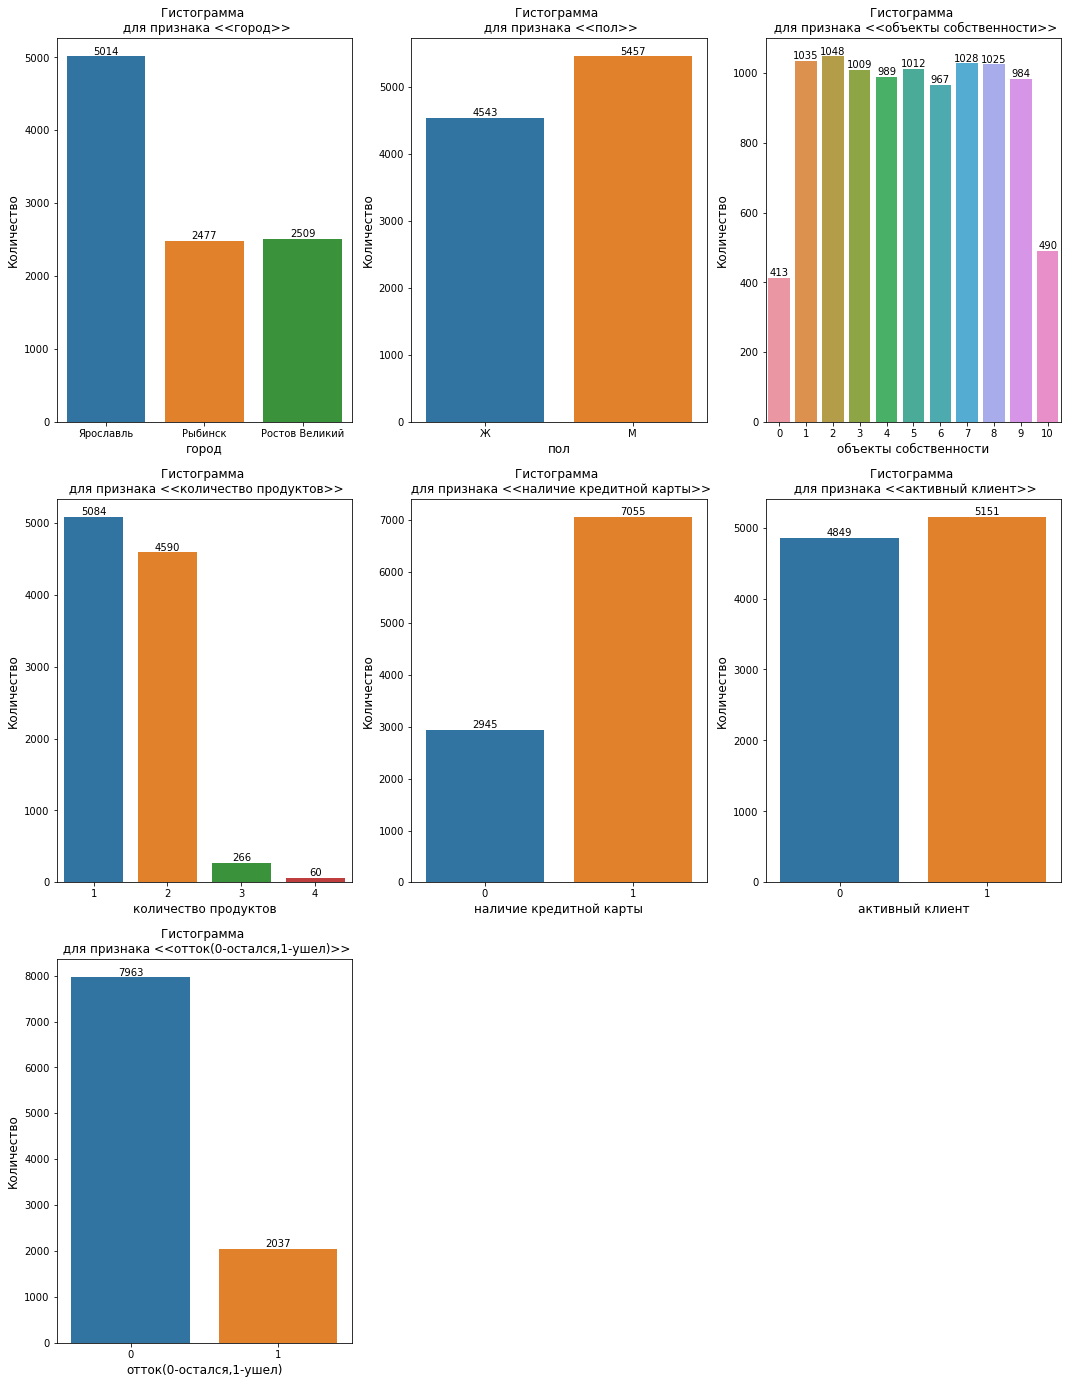

In [60]:
fig, axes = plt.subplots(3, sharey=True, figsize=(18,24))
i=0
for i, col in enumerate(category_):
    plt.subplot(3,3,i+1)
    ax = sns.countplot(x=col, data=df,)
    plt.title("Гистограмма \n для признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col], fontsize = 12)
    plt.ylabel('Количество', fontsize = 12)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:d}'.format(p.get_height()), 
            (x.mean(), y),ha='center', va='bottom', fontsize = 10)

**По получившимся гистограммам можно описать общую краткую картину по имеющимся данным:**

* Основная часть клиентов находятся в городе Ярославль
* По гендерной принадледности, мужчин и женщин в качестве клинтов примерно одинаковое количество (мужчин немного больше)
* Почти у всех клиентов есть объекты в собственности
* Также почти все клиенты пользуются 1-2 банковскими продуктами
* Существенная часть клиентов банка владеет кредитной картой
* Активных и неактивных клиентов в выборке примерно одинаковое количество. В данном случае этот вопрос можно передать специалистам по работе с клиентами для повышения активности
* Больше 20% клиентов являются оттекающими. Далее проанализируем данные и выявим картину оттока 

$\blacktriangleright$ Анализ интервальных признаков 
<a class="anchor" id="interval_var"></a>

In [61]:
interval_ = ['score', 'age', 'balance', 'estimated_salary']

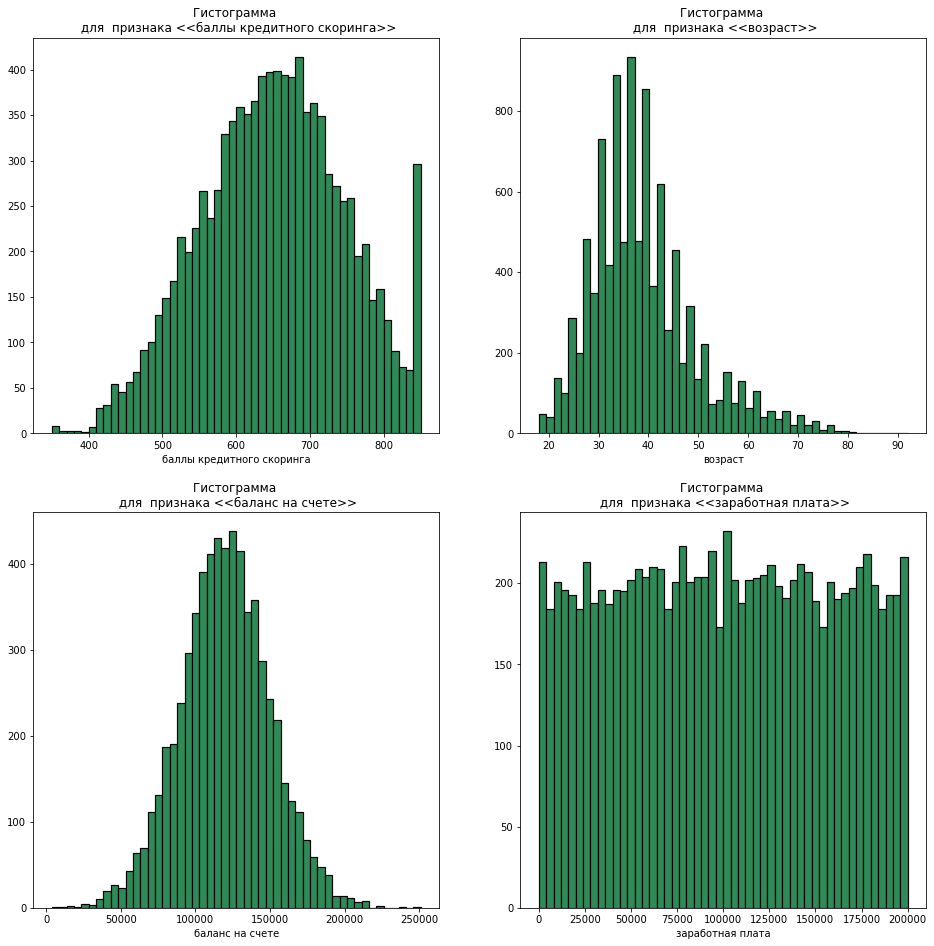

In [62]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16,16))
i = 0
l = 0
j = 0
for i in range(2):
    for j in range(2):
        axes[i, j].hist(df[interval_[l]], bins = 50, color = "seagreen", edgecolor='black', linewidth=1.2)
        axes[i, j].set_title("Гистограмма \n для  признака <<{}>>".format(dict_to_rus[interval_[l]]))
        axes[i, j].set_xlabel(dict_to_rus[interval_[l]])
        l+=1

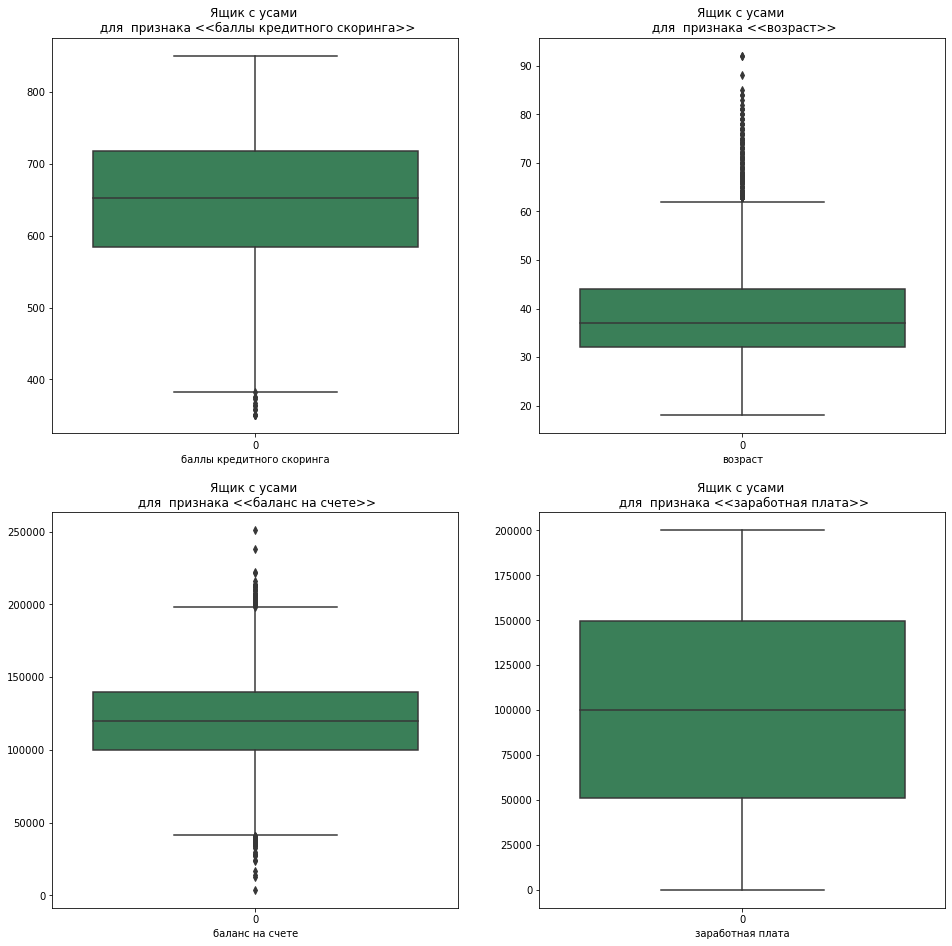

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))
for i, col in enumerate(interval_):
    plt.subplot(2,2,i+1)
    sns.boxplot(data=df[col], whis = 1.5, color = "seagreen")
    plt.title("Ящик с усами \n для  признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col])

#### Судя по построенным графикам можно убрать из выборки значения близкие к аномальным (для лучшего выявления статистики по оттоку).
* По признаку **"возраст"** оставлю значения до 62 лет;
* ------------------**"баланс на счете"** от 42 000 до 200 000;
* ------------------**"баллы кредитного скоринга"** от 400 до 840;
* В **"заработная плата"** ничего менять не буду. Во-первых ящик с усами не показал нам аномальных значений. Во-вторых зар.платы бывают с различной величиной. 

$\blacktriangleright$ Сформируем датафрейм, не содержащий аномальных записей и оценим потери в данных

In [64]:
df_clean = df[(df['age'] <= 62) &
             ((df['score'] >= 400) & (df['score'] <= 840)) &
             ((df['balance'] >= 42000) & (df['balance'] <= 200000))]

In [65]:
sh_old = df.shape[0]
sh_new = df_clean.shape[0]
print('Количество аномальных наблюдений {:d}, что составляет {:.2%} от общего числа записей.'
      .format(sh_old-sh_new, (sh_old-sh_new)/sh_old))

Количество аномальных наблюдений 4108, что составляет 41.08% от общего числа записей.


$\blacktriangleright$ Поскольку количество аномальных записей велико, то их следует проанализировать отдельно. Сформируем датафрейм, в котором будут содержаться только аномальные записи. Соберем эти записи через признак `user_id` и воспользуемся операциями со множествами. 

In [66]:
user_id_anomals = list(set(df.user_id.to_list()) - set(df_clean.user_id.to_list()))
df_user_anomals = df.loc[df['user_id'].isin(user_id_anomals)]
df_user_anomals.shape[0]

4108

На данном этапе провели исследование признаков на аномальные значения. Установлено, что записей с аномальными значениями признаков немного больше 40% от объема исходной выборки. Удалять столько много данных не целесообразно. В итоге сформировали два датафрейма, содержащие:
- записи без аномальных значений признаков;
- записи с аномальными значениями признаков.

В дальнейшем оба датафрейма будут подвергнуты анализу.

### Восстановление пропущенных значений

На данном этапе
- оценим количество пропущенных значений;
- примем решение о судьбе пропусков.

In [67]:
(pd.concat([pd.DataFrame([[df.isna().sum().sum(), df.isna().sum().sum()/df.shape[0]*100], 
                          [df_clean.isna().sum().sum(), df_clean.isna().sum().sum()/df_clean.shape[0]*100], 
                          [df_user_anomals.isna().sum().sum(), 
                         df_user_anomals.isna().sum().sum()/df_user_anomals.shape[0]*100]],
                        index=["Исходный датафрейм", "Датафрейм без аномалий", "Датафрейм с аномалиями"],
                       columns = ['Количество пропусков', 'Процент пропусков'])], 
          axis = 1         
         ).style
.set_caption('Сводная таблица по пропускам в датафреймах')
.format({'Количество пропусков':"{:d}", 'Процент пропусков': '{:.2f}'}))

,Количество пропусков,Процент пропусков
Исходный датафрейм,3617,36.17
Датафрейм без аномалий,0,0.00
Датафрейм с аномалиями,3617,88.05


Видим, что все пропуски собраны в датафрейме с записями, содержащими аномальные значения.

### Визуализация данных после предобработки

Визуализируем данные, не содержащие аномальных значений и пропусков 

$\blacktriangleright$ Категориальные признаки

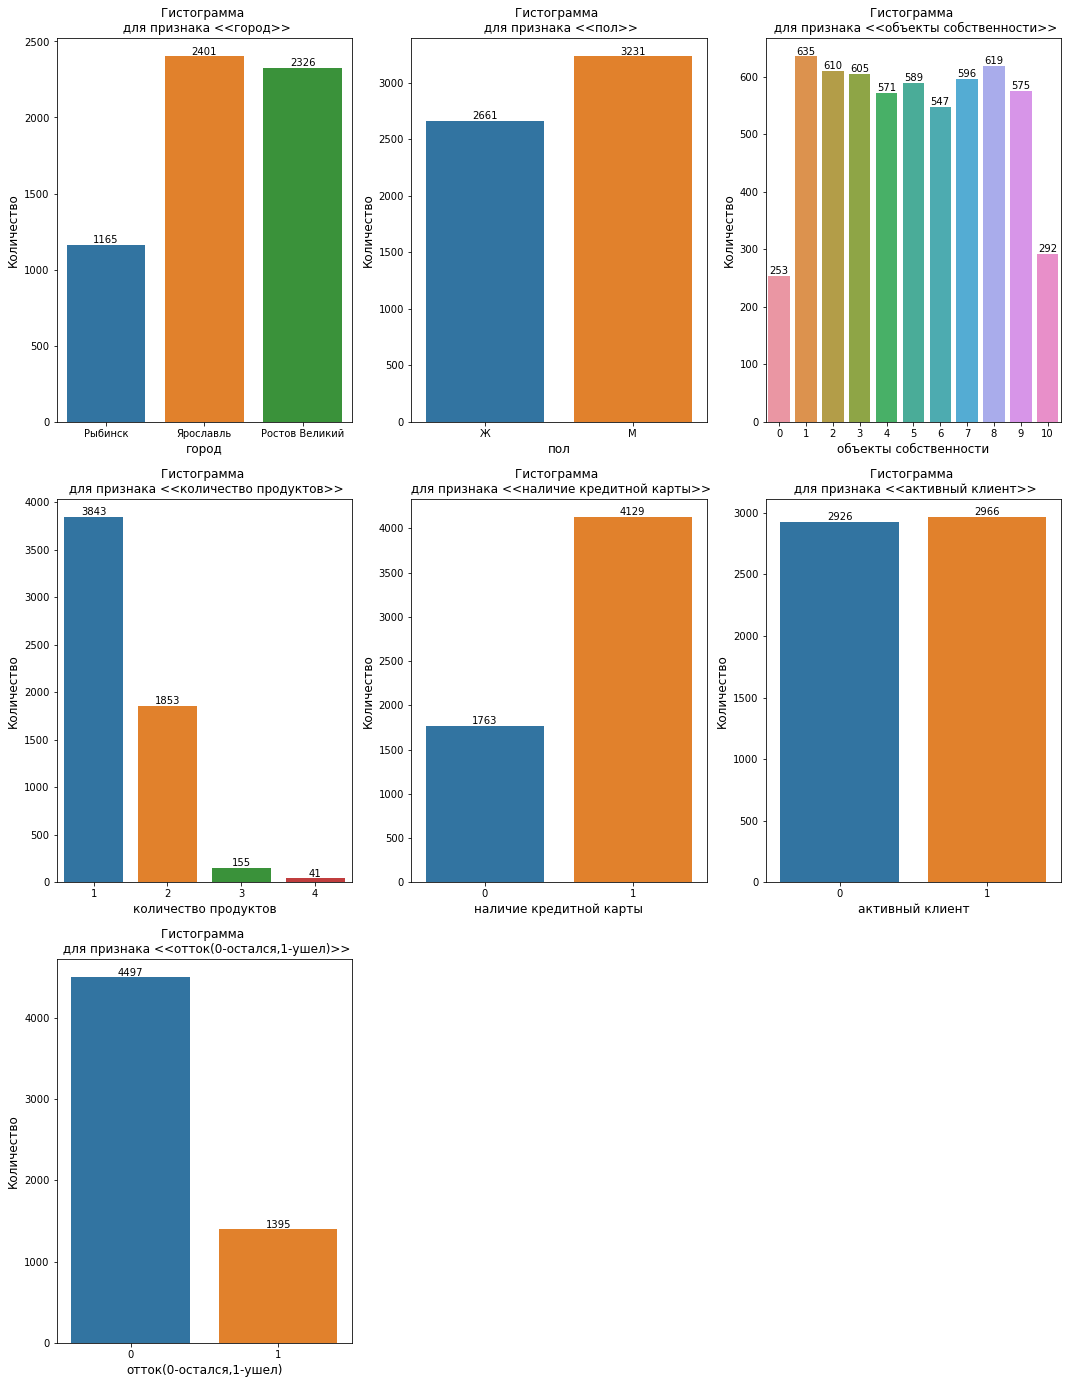

In [68]:
fig, axes = plt.subplots(3, sharey=True, figsize=(18,24))
i=0
for i, col in enumerate(category_):
    plt.subplot(3,3,i+1)
    ax = sns.countplot(x=col, data=df_clean,)
    plt.title("Гистограмма \n для признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col], fontsize = 12)
    plt.ylabel('Количество', fontsize = 12)
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:d}'.format(p.get_height()), 
            (x.mean(), y),ha='center', va='bottom', fontsize = 10)

По очищенным данным признаки корректно показали значения. Если сравнивать с этими же признаками до обработки, то можно заметить, что в целом картина не изменилась, за исключением признака `city`. г.Ростов Великий почти сравнялся с г.Ярославль по количеству клиентов. В свою очередь в г.Рыбинск количество клиентов почти в 2 раза меньше, чем в остальных. Отсюда видим по клиентам из Ярославля и Рыбинска имеем много потерь по данным. Может надо наладить работу офисов...

$\blacktriangleright$ Интервальные признаки

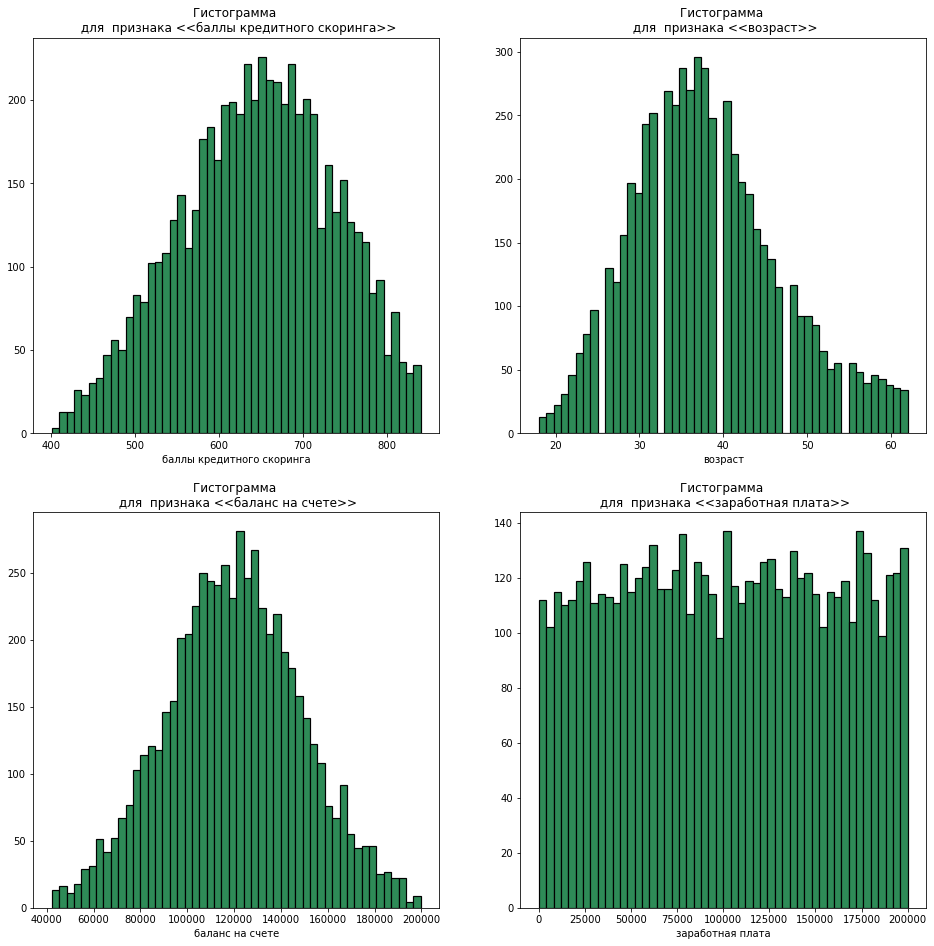

In [69]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16,16))
i = 0
l = 0
j = 0
for i in range(2):
    for j in range(2):
        axes[i, j].hist(df_clean[interval_[l]], bins = 50, color = "seagreen", edgecolor='black', linewidth=1.2)
        axes[i, j].set_title("Гистограмма \n для  признака <<{}>>".format(dict_to_rus[interval_[l]]))
        axes[i, j].set_xlabel(dict_to_rus[interval_[l]])
        l+=1

После очистки данных интервальные значения на гистограммах выгледят более распределенными. Выбросов не наблюдается. 

### Исследовательский анализ данных

На данном шаге выявим какие-либо различия в характеристиках признаков (по группам ушел/остался) и сформулируем соответствующие гипотезы

### Гистограммы и распределения: интервальные признаки

$\blacktriangleright$ Визуализация [**интервальных признаков**](#interval_var) датафрейма без аномалий 

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


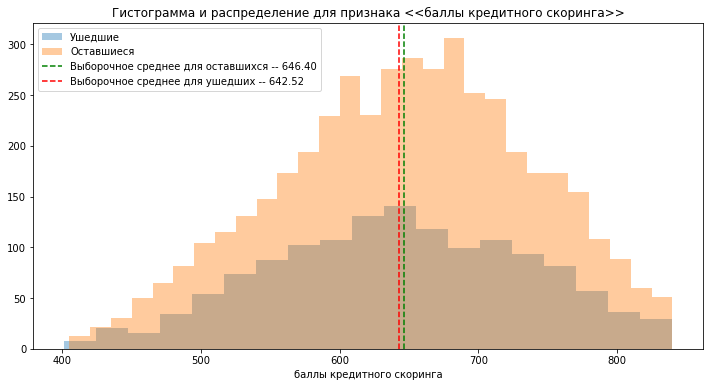

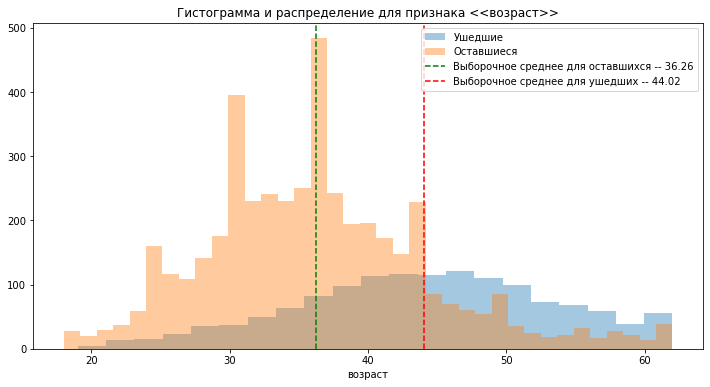

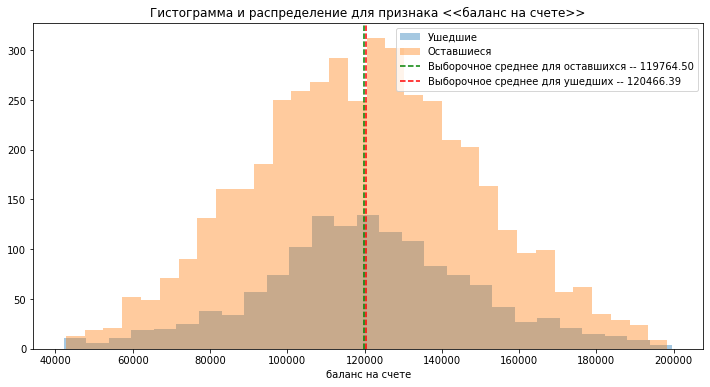

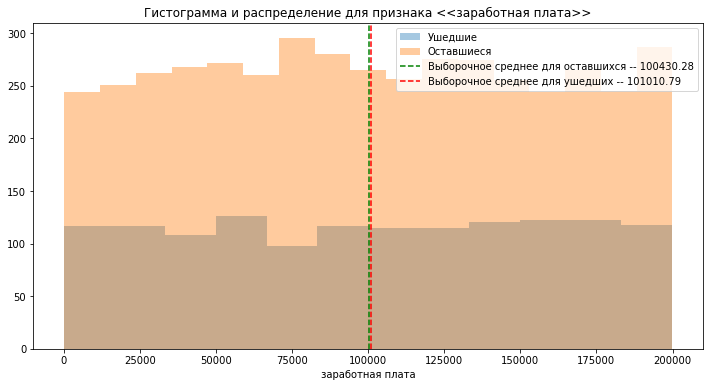

In [76]:
for col in interval_:
    plt.figure(figsize=(12,6))
    sns.distplot(df_clean[df_clean.churn == 1][col], label = 'Ушедшие', kde = False)
    sns.distplot(df_clean[df_clean.churn == 0][col], label = 'Оставшиеся', kde = False)
    plt.axvline(df_clean[df_clean.churn == 0][col].mean(),
            color='green',linestyle='--', 
            label = 'Выборочное среднее для оставшихся -- {:.2f}'.\
            format(df_clean[df_clean.churn == 0][col].mean()));
    plt.axvline(df_clean[df_clean.churn == 1][col].mean(),
            color='red',linestyle='--', 
            label = 'Выборочное среднее для ушедших -- {:.2f}'.\
            format(df_clean[df_clean.churn == 1][col].mean()));
    plt.title("Гистограмма и распределение для признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col])
    plt.legend( )
    plt.show()

$\blacktriangleright$ Визуализация [**интервальных признаков**](#interval_var) датафрейма с аномалиями 

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


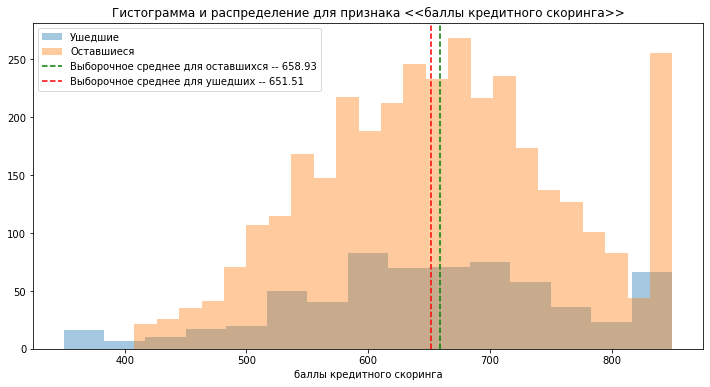

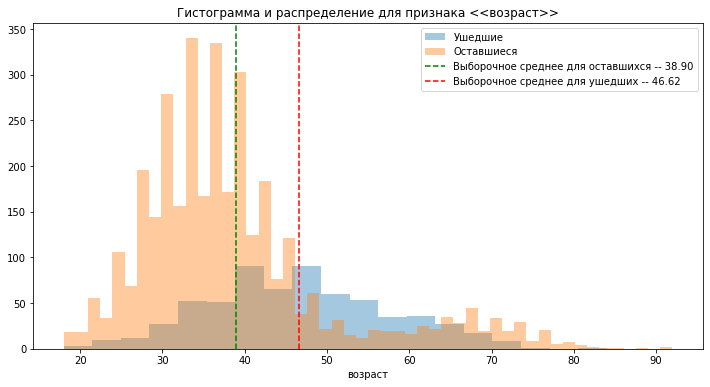

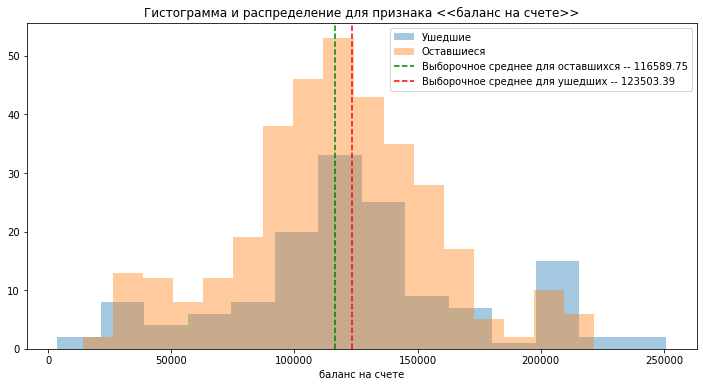

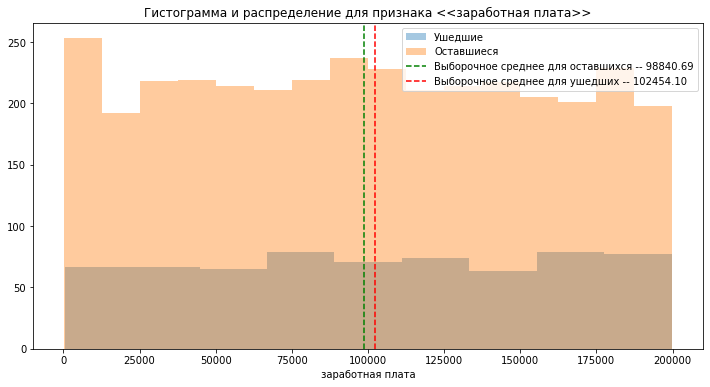

In [80]:
for col in interval_:
    plt.figure(figsize=(12,6))
    sns.distplot(df_user_anomals[df_user_anomals.churn == 1][col], label = 'Ушедшие', kde = False)
    sns.distplot(df_user_anomals[df_user_anomals.churn == 0][col], label = 'Оставшиеся', kde = False)
    plt.axvline(df_user_anomals[df_user_anomals.churn == 0][col].mean(),
            color='green',linestyle='--', 
            label = 'Выборочное среднее для оставшихся -- {:.2f}'.\
            format(df_user_anomals[df_user_anomals.churn == 0][col].mean()));
    plt.axvline(df_user_anomals[df_user_anomals.churn == 1][col].mean(),
            color='red',linestyle='--', 
            label = 'Выборочное среднее для ушедших -- {:.2f}'.\
            format(df_user_anomals[df_user_anomals.churn == 1][col].mean()));
    plt.title("Гистограмма и распределение для признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col])
    plt.legend( )
    plt.show()

<a class="anchor" id="int_gyp"></a>
Полученные графики по [интервальным признакам](#interval_var) позволяют сделать промежуточные выводы:   
- <span style=color:red> $\checkmark$ </span> выдвинуть гипотезу о том, что имеется статистически значимое различие между средним возрастом оставшихся и ушедших клиентов;
- <span style=color:green> $\checkmark$ </span> по другим признакам исследуемых групп (оставшихся/ушедших) невозможно выдвинуть подобные гипотезы, поскольку представленные плотности распределений (нормальное и равномерное) очень схожи как для оставшихся, так и ушедших клиентов. Иными словами, для признаков `score`, `balance` и `estimated_salary` плотности их распределений для групп оставшихся и ушедших клиентов совпадают.

### Изучение признаков по группам: категориальные признаки

Для групп оставшихся и ушедших клиентов построим гистораммы для [категориальных признаков](#category_var). Традиционно выполним анализ обоих датафреймов. Однако, прежде, чем переходить к анализу подвергнем модификации набор категориальных признаков, убрав из него признак `churn`.

$\blacktriangleright$ Модификация набора [**категориальных признаков**](#category_var)

In [78]:
cat_var = list(set(category_) - set(['churn']))
cat_var

['loyalty', 'credit_card', 'gender', 'city', 'products', 'objects']

$\blacktriangleright$ Визуализация **категориальных признаков** датафрейма без аномалий

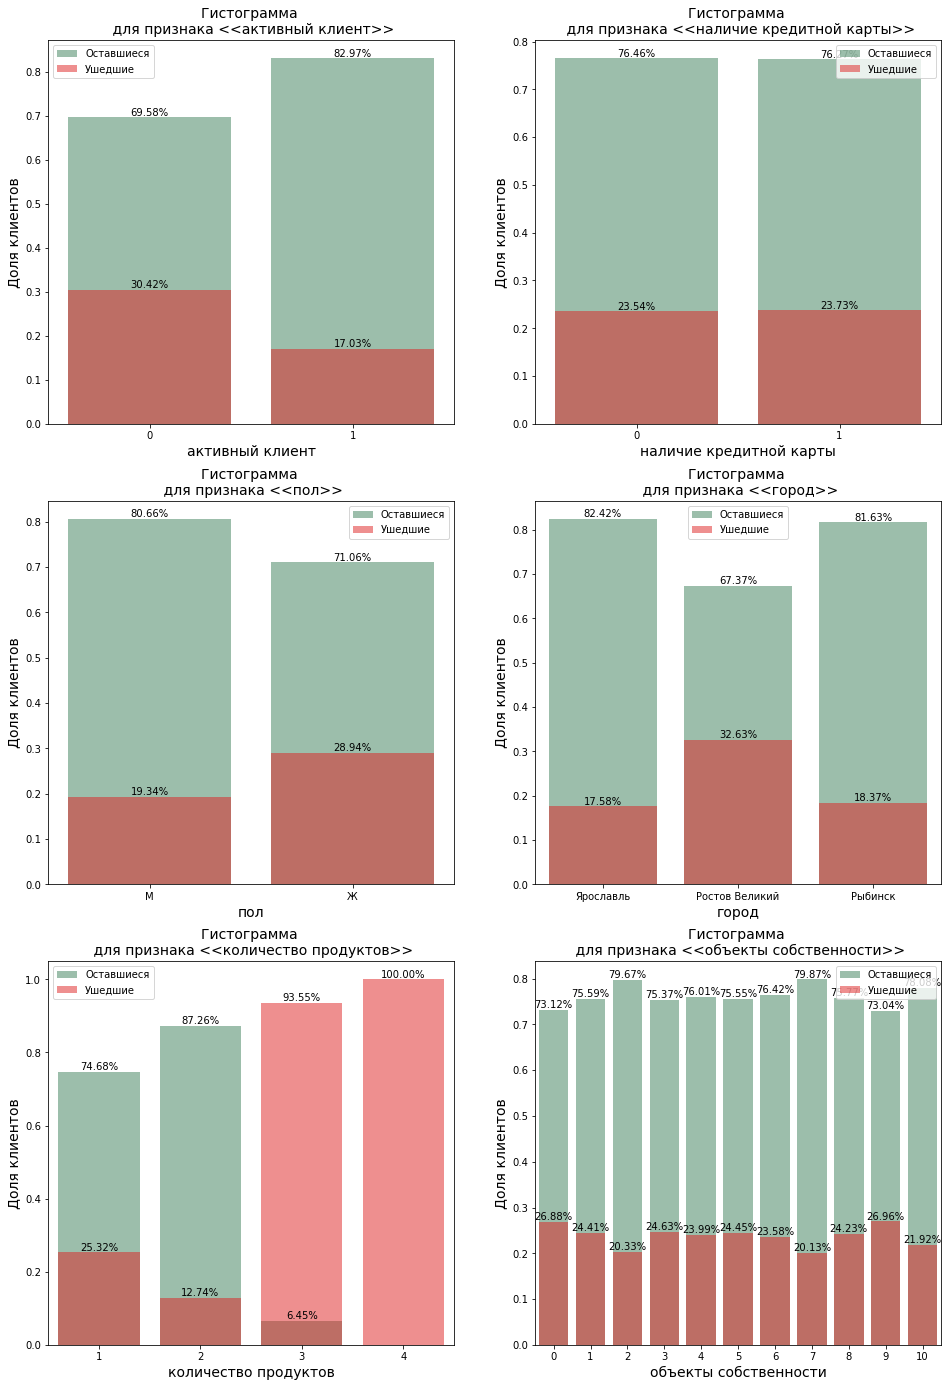

In [79]:
fig, axes = plt.subplots(3, figsize=(16,24))
i=0
for i, col in enumerate(cat_var):
    plt.subplot(3,2,i+1)
    data_all = df_clean[col].value_counts()
    r = (pd.DataFrame([df_clean[df_clean.churn == 0][col].value_counts()/data_all, 
              df_clean[df_clean.churn == 1][col].value_counts()/data_all]).T)
    r.columns = ['0','1']
    ax1 = sns.barplot(x = r.index, y = r['0'], data = r, color='seagreen',
                      alpha = 0.5, label = 'Оставшиеся')
    ax2 = sns.barplot(x = r.index, y = r['1'], data = r, color='red', 
                      alpha = 0.5, label = 'Ушедшие')
    plt.title("Гистограмма \n для признака <<{}>>".format(dict_to_rus[col]), fontsize = 14)
    plt.xlabel(dict_to_rus[col], fontsize = 14)
    plt.ylabel('Доля клиентов', fontsize = 14)
    plt.legend()
    for p in ax1.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax1.annotate('{:.2f}%'.format(100*y), 
            (x.mean(), y),ha='center', va='bottom', fontsize = 10)

$\blacktriangleright$ Визуализация **категориальных признаков** датафрейма с аномалиями

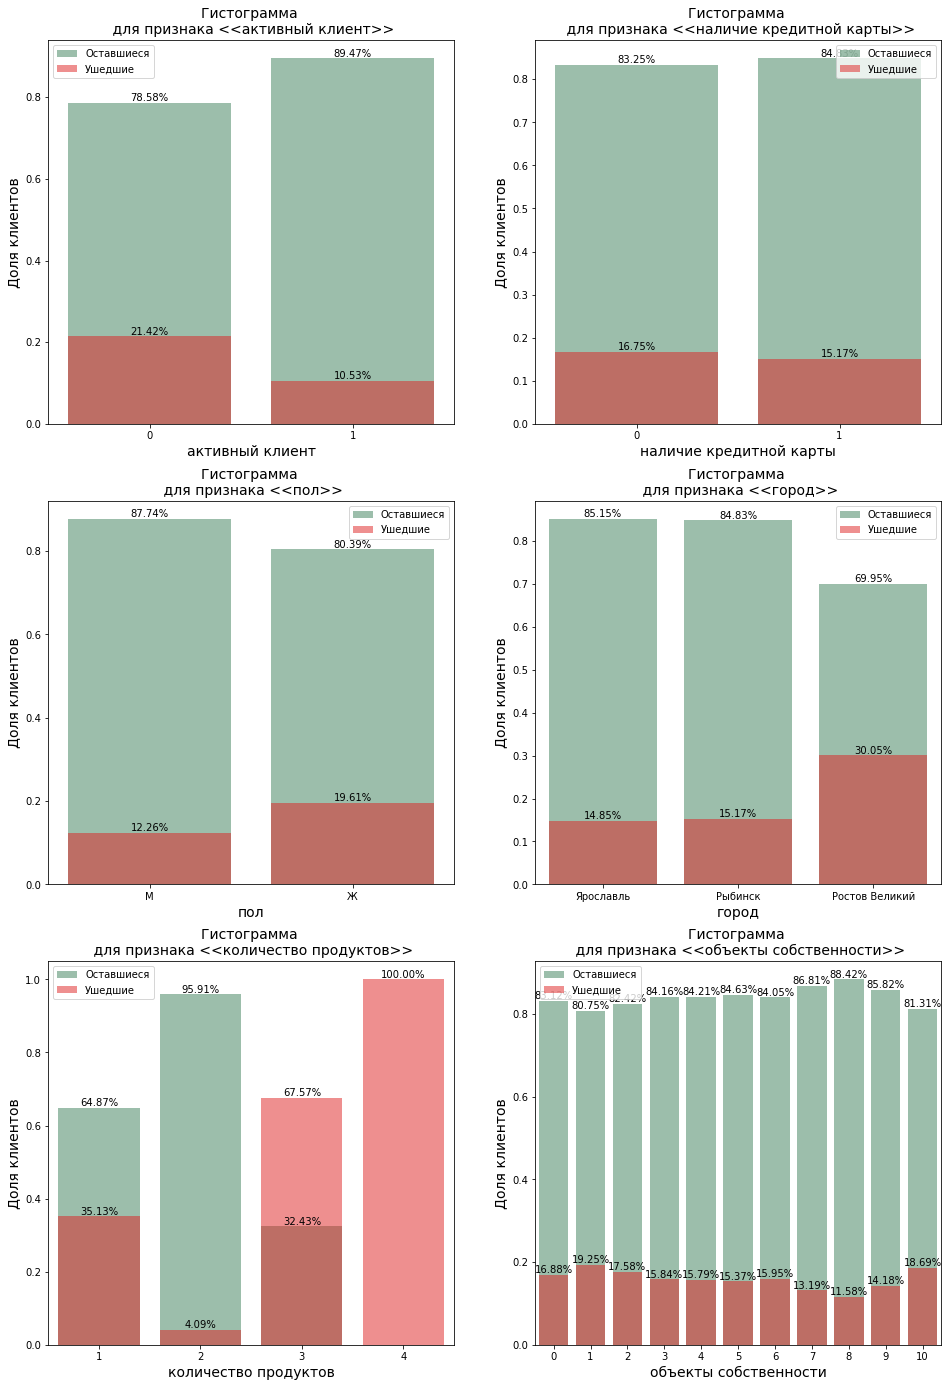

In [81]:
fig, axes = plt.subplots(3, figsize=(16,24))
i=0
for i, col in enumerate(cat_var):
    plt.subplot(3,2,i+1)
    data_all = df_user_anomals[col].value_counts()
    r = (pd.DataFrame([df_user_anomals[df_user_anomals.churn == 0][col].value_counts()/data_all, 
              df_user_anomals[df_user_anomals.churn == 1][col].value_counts()/data_all]).T)
    r.columns = ['0','1']
    ax1 = sns.barplot(x = r.index, y = r['0'], data = r, color='seagreen',
                      alpha = 0.5, label = 'Оставшиеся')
    ax2 = sns.barplot(x = r.index, y = r['1'], data = r, color='red', 
                      alpha = 0.5, label = 'Ушедшие')
    plt.title("Гистограмма \n для признака <<{}>>".format(dict_to_rus[col]), fontsize = 14)
    plt.xlabel(dict_to_rus[col], fontsize = 14)
    plt.ylabel('Доля клиентов', fontsize = 14)
    plt.legend()
    for p in ax1.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax1.annotate('{:.2f}%'.format(100*y), 
            (x.mean(), y),ha='center', va='bottom', fontsize = 10)

Проведем анализ построенных гистограмм для категориальных признаков:
- <span style=color:red> $\checkmark$ </span> по признаку `city` наблюдаются различия. Клиенты из `Ростова Великого` **склонны к оттоку**; 
- <span style=color:red> $\checkmark$ </span> по признаку `gender` наблюдаются различия. Женщины склонны к оттоку;
- <span style=color:green> $\checkmark$ </span> по признаку `objects` различий не замечено;
- <span style=color:green> $\checkmark$ </span> по признаку `credit_card` различий не замечено;
- <span style=color:red> $\checkmark$ </span> по признаку `products`, конечно, глядя на соотвествующие гистограммы, сложно не заметить различия и здесь можно было бы сказать, что *к оттоку склонны клиенты с большим количеством банковских продуктов*, наверное, искали приемленые для себя продукты (объясняется большое кол-во), не нашли и ушли. Однако, заметим следующее. Клиентов с `3` или `4` банковскими продуктами во всей! выборке всего 326 или 0.0326%, что, конечно, очень мало для формирования каких-либо значимых утверждений. Выдвинем смелое противоположное суждение, что **клиенты с 1 банковским продуктом склонны к оттоку**;      
- <span style=color:red> $\checkmark$ </span> по признаку `loyalty` наблюдаются различия. Видим, что **неактивные клиенты более склонны к оттоку, чем активные**. Для этого признака подобное поведение как раз норма.

### Корреляционный анализ

Для исследуемого признакового пространства рассчитаем матрицу корреляций. Необходимо заметить, что теория не позволяет считать коэффициенты корреляции для исследуемого признакового пространства.    

Однако, прежде обратим внимание, что признаки `city` и `gender` представляют собой строковый тип данных, поэтому их надо преобразовать в количественный тип данных. Для преобразования воспользуемся методом [**`.get_dummies`**](https://www.machinelearningmastery.ru/beginners-guide-to-encoding-data-5515da7f56ab/).

Это несколько увеличит размерность признакового пространства, но ради попытки применения методов `ML` к решению поставленной задачи пойдем на это увеличение. 

**ЗАМЕЧАНИЕ:**  В этом разделе в дальнейшем:
- будем работать только с датафреймом, содержащим записи без аномальных значений;
- исключим из рассмотрения признак `user_id`, т.к. здесь он нам не поможет точно. 

$\blacktriangleright$ Кодирование значений признаков `city` и `gender`

In [83]:
df_ml = pd.get_dummies(df_clean)
df_ml

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
5,15616748,645,44,8,113755.78,2,1,0,149756.71,1,0,1,0,0,1
8,15835101,501,44,4,142051.07,2,0,1,74940.50,0,0,0,1,0,1
9,15635125,684,27,2,134603.88,1,1,1,71725.73,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,15812695,597,53,4,88381.21,1,1,0,69384.71,1,0,0,1,1,0
9993,15612002,644,28,7,155060.41,1,1,0,29179.52,0,0,0,1,0,1
9996,15612628,516,35,10,57369.61,1,1,1,101699.77,0,0,0,1,0,1
9998,15725091,772,42,3,75075.31,2,1,0,92888.52,1,1,0,0,0,1


$\blacktriangleright$ Формирование признакового пространства: переименуем новые признаки, сформируем анализируемый набор признаков

In [84]:
df_ml.drop('user_id', axis = 1, inplace = True)

In [85]:
df_ml.rename(columns = {'city_Ростов Великий':'city_rostov', 
                      'city_Рыбинск':'city_rybinsk', 
                      'city_Ярославль':'city_yaroslavl', 
                      'gender_Ж':'gender_w', 
                      'gender_М':'gender_m'}, inplace = True);

$\blacktriangleright$ Матрица корреляций

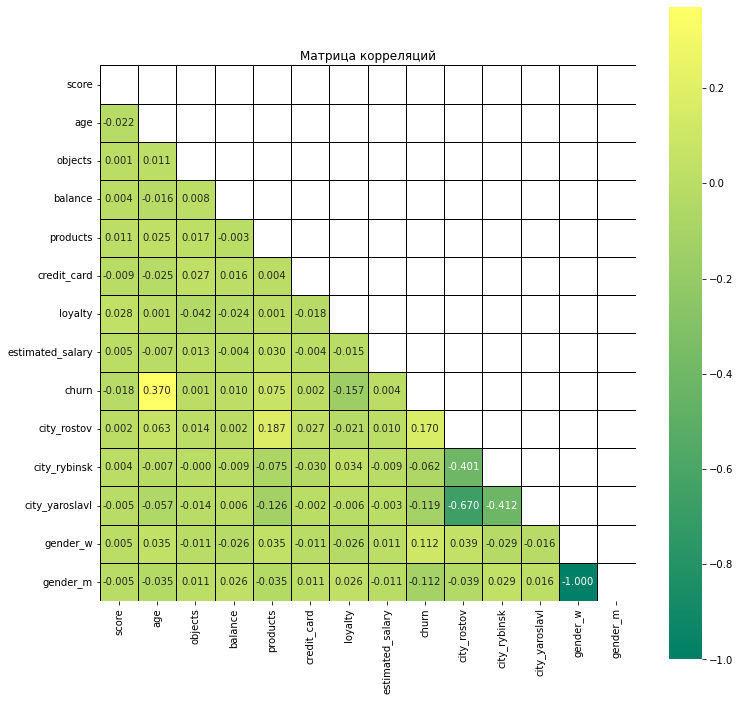

In [86]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(data = df_ml.corr(), annot=True, square=True, 
            cmap='summer', fmt='.3f', linewidths=1, linecolor='black', mask=np.triu(df_ml.corr()))
plt.title('Матрица корреляций')
plt.show()

**Промежуточный вывод по матрице корреляций:** Видим, что признак `churn` имеет наибольший положительный коэффициент корреляции с признаком `age`. Это означает, чем больше значение признака `age` (клиент старше), тем больше значение признака `churn` (стремится к 1, а значит склонен к ухода). Данный результат косвенно подтверждает [**выдвинутую выше гипотезу**](#int_gyp) о  наличие статистически значимой разницы в возрасте оставшихся и ушедших клиентов.

Отметим также признаки `loyalty`, `city_yaroslavl` и `gender_m`. Эти признаки имеют отрицательные коэффициенты корреляции с целевым признаком `churn`. Это означает, чем больше значение признака этих признаков (стремится к 1 --- клиент является активным или клиент из Ярославля, или клиент является мужчиной), тем меньше значение признака `churn` (стремится к 0 --- клиент склонен остаться).

Для признака `churn` из оставшихся **положительных** значений выделим также коэффициенты корреляции с признаками `city_rostov` и `gender_w`.  

### Кластеризация: агломеративный алгоритм по Уорду и k-means

Поскольку нас интересуют, прежде всего, портреты клиентов, склонных к оттоку, то выделим из анализируемого датафрейма ушедших клиентов и выполним кластеризацию. Для полной картины кластеризуем и оставшихся клиентов.

Для выполнения кластеризации (сегментации) клиентов реализуем следующие этапы:
- Разделим выборку на ушедших и оставшихся;
- Сформируем признаковое пространство, убрав целевой признак;
- Масштабируем данные;
- Реализуем иерархическую агломеративную кластеризацию методом .linkage() и для визуализации результата методом .dendrogram() построим дендрограмму. На даннном этапе по дендрограмме, задав уровень отсечения, можно установить оптимальное число кластеров. Здесь, однако, не будем полагаться только на дендрограмму, а воспользуемся еще и методом локтя;
- Определив число кластеров, обучим модель кластеризации на основании алгоритма k-means и спрогнозируем кластеры клиентов;
- Исследуем средние значения признаков для кластеров;
- Для каждого полученного кластера посчитаем долю оттока;
- Построим распределения признаков для кластеров.

$\blacktriangleright$ Кластеризация ушедших клиентов

In [87]:
df_ml_churn = df_ml[df_ml.churn == 1]
X = df_ml_churn.drop(['churn'], axis = 1)
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

$\blacktriangleright$ Алгомеративная кластеризация и дендрограмма

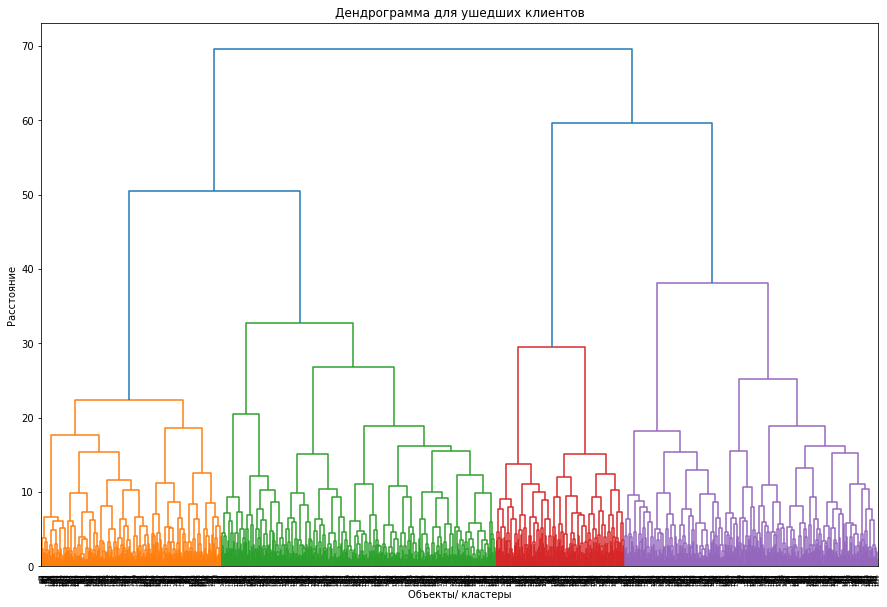

In [88]:
plt.figure(figsize=(15, 10))
Z = linkage(X_st, method='ward') 
plt.title('Дендрограмма для ушедших клиентов')
plt.xlabel('Объекты/ кластеры')
plt.ylabel('Расстояние')
dendrogram(Z, orientation='top')
plt.show();

Видим 4 кластера. Далее воспользуемся еще "методом локтя".

$\blacktriangleright$ Усеченная дендрограмма: визуализация заданного числа кластеров

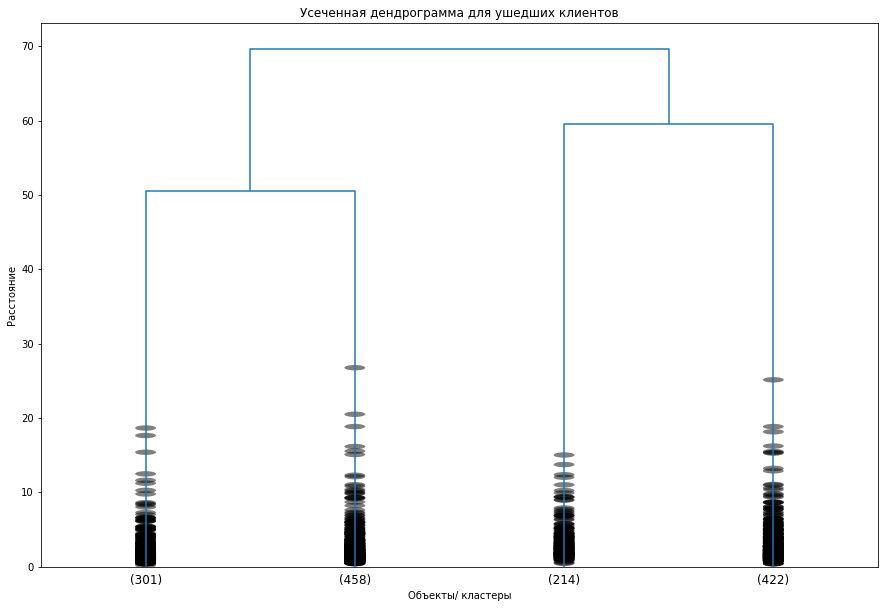

In [89]:
plt.figure(figsize=(15, 10))
dendrogram(Z, 
           truncate_mode = 'lastp',
           p=4,                    
           show_contracted = True)
plt.title('Усеченная дендрограмма для ушедших клиентов')
plt.xlabel('Объекты/ кластеры')
plt.ylabel('Расстояние')
plt.show();

In [90]:
agl_cluster_label = fcluster(Z, 4, criterion='maxclust')
agl_cluster_label

array([4, 3, 1, ..., 2, 4, 1], dtype=int32)

$\blacktriangleright$ Метод "локтя". Воспользуемся данным методом для определения оптимального числа кластеров

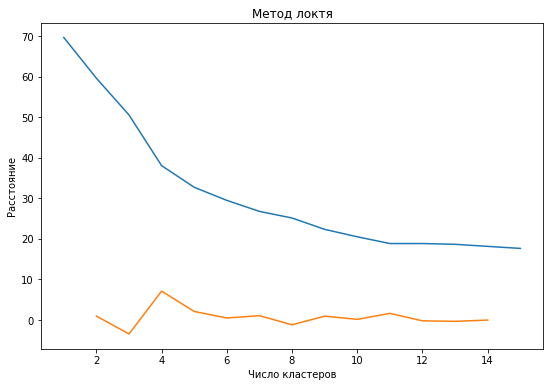

Оптимальное число кластеров: 4


In [91]:
plt.figure(figsize=(9, 6))
last = Z[-15:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1,1)
plt.xlabel('Число кластеров')
plt.ylabel('Расстояние')
plt.title('Метод локтя')
plt.plot(idxs, last_rev)
acceleration = np.diff(last, 2)
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2
print("Оптимальное число кластеров:", k)

Проведена иерархическая кластеризация, результаты которой представлены в виде дендрограммы. Выделяется 4 кластера и это хорошо согласуется с методом "локтя". Запомнили метки кластеров для объектов (клиентов).

$\blacktriangleright$ Неиерархическая кластеризация методом `k-means`. Прогнозирование меток кластеров для объектов(клиентов).

Число кластеров `k=4`.

In [92]:
km = KMeans(n_clusters = 4, random_state = 42)
notagl_cluster_label = km.fit_predict(X_st)

$\blacktriangleright$ Записываем метки кластеров для клиентов и сравним результаты кластеризации хотя бы по численности кластеров 

In [93]:
df_ml_churn = pd.DataFrame(df_ml_churn)
df_ml_churn

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_rostov,city_rybinsk,city_yaroslavl,gender_w,gender_m
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
5,645,44,8,113755.78,2,1,0,149756.71,1,0,1,0,0,1
16,653,58,1,132602.88,1,1,0,5097.67,1,1,0,0,0,1
35,475,45,0,134264.04,1,1,0,27822.99,1,0,0,1,1,0
41,465,51,8,122522.32,1,0,0,181297.65,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,610,50,1,113957.01,2,1,0,196526.55,1,1,0,0,0,1
9981,498,42,3,152039.70,1,1,1,53445.17,1,1,0,0,0,1
9982,655,46,7,137145.12,1,1,0,115146.40,1,1,0,0,1,0
9991,597,53,4,88381.21,1,1,0,69384.71,1,0,0,1,1,0


In [94]:
df_ml_churn = pd.DataFrame(df_ml_churn)
df_ml_churn['agl_cluster_label'] = agl_cluster_label
df_ml_churn['notagl_cluster_label'] = notagl_cluster_label

In [95]:
df_ml_churn.groupby('agl_cluster_label')['agl_cluster_label'].count()

agl_cluster_label
1    301
2    458
3    214
4    422
Name: agl_cluster_label, dtype: int64

In [96]:
df_ml_churn.groupby('notagl_cluster_label')['notagl_cluster_label'].count()

notagl_cluster_label
0    214
1    422
2    341
3    418
Name: notagl_cluster_label, dtype: int64

In [97]:
rating_cluster = df_ml_churn.groupby('agl_cluster_label').mean().reset_index().sort_values(by = 'churn', ascending = False)
rating_cluster.T

,0,1,2,3
agl_cluster_label,1.00,2.00,3.00,4.00
score,637.11,648.72,641.52,640.15
age,44.34,44.02,42.95,44.33
objects,4.86,5.19,4.75,5.00
balance,120612.39,120198.08,118268.08,121768.22
products,1.21,1.61,1.50,1.47
credit_card,0.69,0.72,0.65,0.71
loyalty,0.34,0.39,0.36,0.36
estimated_salary,97539.65,99103.61,106500.97,102772.41
churn,1.00,1.00,1.00,1.00


In [98]:
rating_cluster_k_means = df_ml_churn.groupby('notagl_cluster_label').mean().reset_index().sort_values(by = 'churn', ascending = False)
rating_cluster_k_means.T

,0,1,2,3
notagl_cluster_label,0.00,1.00,2.00,3.00
score,641.52,640.15,639.27,648.06
age,42.95,44.33,44.35,43.98
objects,4.75,5.00,4.98,5.12
balance,118268.08,121768.22,121114.14,119749.12
products,1.50,1.47,1.44,1.46
credit_card,0.65,0.71,0.72,0.71
loyalty,0.36,0.36,0.35,0.38
estimated_salary,106500.97,102772.41,96675.23,99958.45
churn,1.00,1.00,1.00,1.00


$\blacktriangleright$ Кластеризация оставшихся клиентов

In [99]:
df_ml_not_churn = df_ml[df_ml.churn == 0]
X = df_ml_not_churn.drop(['churn'], axis = 1)
scaler = StandardScaler()
X_st = scaler.fit_transform(X)

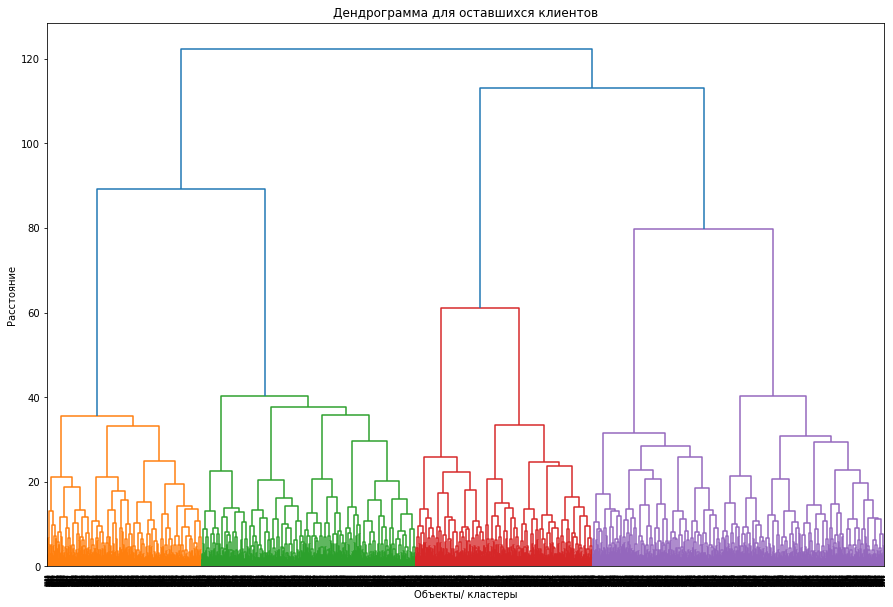

In [100]:
plt.figure(figsize=(15, 10))
Z = linkage(X_st, method='ward') 
plt.title('Дендрограмма для оставшихся клиентов')
plt.xlabel('Объекты/ кластеры')
plt.ylabel('Расстояние')
dendrogram(Z, orientation='top')
plt.show();

Видим 4 класса. Далее воспользуемся еще "методом локтя".

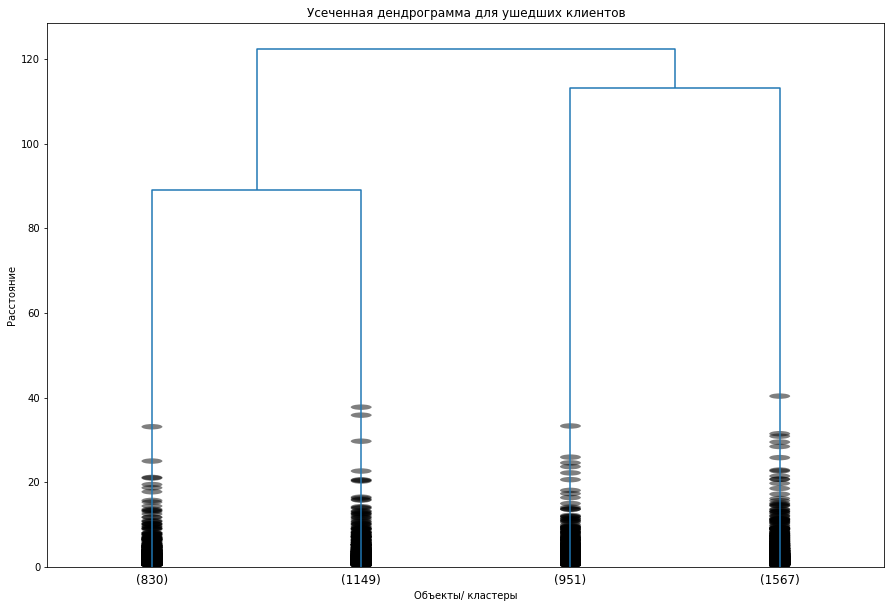

In [101]:
plt.figure(figsize=(15, 10))
dendrogram(Z, 
           truncate_mode = 'lastp',
           p=4,                    
           show_contracted = True)
plt.title('Усеченная дендрограмма для ушедших клиентов')
plt.xlabel('Объекты/ кластеры')
plt.ylabel('Расстояние')
plt.show();

In [102]:
agl_cluster_label_not_churn = fcluster(Z, 4, criterion='maxclust')
agl_cluster_label_not_churn

array([3, 2, 2, ..., 2, 2, 1], dtype=int32)

$\blacktriangleright$ Метод "локтя". Воспользуемся данным методом для определения оптимального числа кластеров

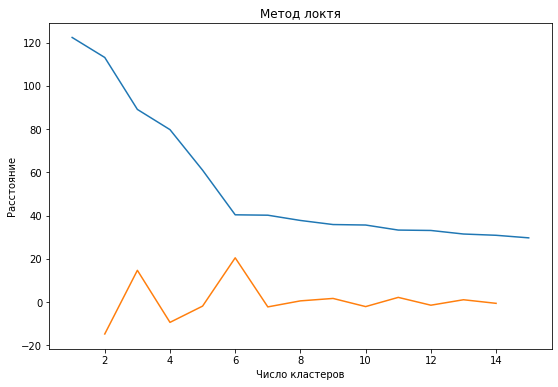

Оптимальное число кластеров: 6


In [103]:
plt.figure(figsize=(9, 6))
last = Z[-15:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1,1)
plt.xlabel('Число кластеров')
plt.ylabel('Расстояние')
plt.title('Метод локтя')
plt.plot(idxs, last_rev)
acceleration = np.diff(last, 2)
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2
print("Оптимальное число кластеров:", k)

$\blacktriangleright$ Неиерархическая кластеризация методом `k-means`. Прогнозирование меток кластеров для объектов(клиентов).

Согласно методу локтя оптимальное число кластеров `k=6`.

In [104]:
km = KMeans(n_clusters = 6, random_state = 42)
notagl_cluster_label_not_churn = km.fit_predict(X_st)

In [105]:
df_ml_not_churn = pd.DataFrame(df_ml_not_churn)
df_ml_not_churn['agl_cluster_label_not_churn'] = agl_cluster_label_not_churn
df_ml_not_churn['notagl_cluster_label_not_churn'] = notagl_cluster_label_not_churn

In [106]:
rating_cluster_agl = df_ml_not_churn.groupby('agl_cluster_label_not_churn').mean().reset_index().sort_values(by = 'churn', ascending = False)
rating_cluster_agl.T

,0,1,2,3
agl_cluster_label_not_churn,1.00,2.00,3.00,4.00
score,643.42,647.75,647.32,646.42
age,35.56,36.37,36.86,36.20
objects,4.82,5.01,5.04,5.03
balance,118722.14,120549.19,119644.68,119813.97
products,1.29,1.24,1.26,1.55
credit_card,0.68,0.71,0.68,0.72
loyalty,0.53,0.53,0.58,0.55
estimated_salary,98607.33,100748.87,98008.24,102632.18
churn,0.00,0.00,0.00,0.00


In [107]:
rating_cluster_agl = df_ml_not_churn.groupby('notagl_cluster_label_not_churn').mean().reset_index().sort_values(by = 'churn', ascending = False)
rating_cluster_agl.T

,0,1,2,3,4,5
notagl_cluster_label_not_churn,0.00,1.00,2.00,3.00,4.00,5.00
score,647.75,643.42,650.80,646.66,645.08,646.12
age,36.37,35.56,36.86,35.92,36.86,36.55
objects,5.01,4.82,5.10,5.13,5.01,4.91
balance,120549.19,118722.14,120087.15,120465.59,119360.40,118983.60
products,1.24,1.29,1.26,1.57,1.26,1.54
credit_card,0.71,0.68,0.69,0.72,0.67,0.71
loyalty,0.53,0.53,0.57,0.57,0.58,0.52
estimated_salary,100748.87,98607.33,96794.88,101192.97,98787.80,104466.17
churn,0.00,0.00,0.00,0.00,0.00,0.00


**Промежуточный вывод по кластеризации:** Имеем следующие отличительные характеристики результатов кластеризации по группам ушедших и оставшихся клиентов:

| Признак | Кластеры для ушедших клиентов | Кластеры для оставшихся клиентов | Комментарий
|---:|---:|---:|---:|
|`score`| Центроиды принимают значения из $[637; 648]$ | Центроиды принимают значения из $[643; 650]$ |У клиентов, **склонных к оттоку**, баллы кредитного скоринга немного ниже|
|`age`|Центроиды принимают значения из $[42; 44]$ | Центроиды принимают значения из $[35; 36]$ |У клиентов, **склонных к оттоку**, возраст больше|
|`objects`|Центроиды принимают значения из $[4; 5]$ | Центроиды принимают значения из $[4; 5]$ |Здесь не установлено влияние данного признака на склонность к оттоку, как и к тому, чтобы остаться| 
|`balance`|Центроиды принимают значения из $[118268; 121768]$|Центроиды принимают значения из $[118722; 120549]$ |У клиентов, **склонных к оттоку**, баланс на счет немного больше, чем у оставшихся клиентов. Возможно у ушедших истек срок вклада, они и ушли. Этим можно объяснить нребольшую разницу на счете|
|`products`|Центроиды принимают значения из $[1.21; 1.61]$|Центроиды принимают значения из $[1.24; 1.57]$|Здесь не установлено влияние данного признака на склонность к оттоку, как и к тому, чтобы остаться| 
|`credit_card`|Центроиды принимают значения из $[0.65; 0.72]$|Центроиды принимают значения из $[0.67; 0.72]$|Здесь не установлено влияние данного признака на склонность к оттоку, как и к тому, чтобы остаться| 
|`loyalty`|Центроиды принимают значения из $[0.34; 0.39]$|Центроиды принимают значения из $[0.52; 0.58]$|У клиентов, **склонных к оттоку**, активность ниже|
|`estimated_salary`|Центроиды принимают значения из $[96675; 106500]$|Центроиды принимают значения из $[98008; 104466]$| У клиентов, **склонных к оттоку**, заработная плата немного больше| 
|`city_rostov`|Уход в двух кластерах|Остаются в одном/двух кластерах|Клиенты из `Ростова Великого` **склонны к оттоку**|
|`city_rybinsk`|Уход в одном кластере|Остаются в одном/двух кластерах|Клиенты из `Рыбинска` **не склонны к оттоку**|
|`city_yaroslavl`|Уход в одном кластере|Остаются в двух кластерах |Клиенты из `Ярославля` **не склонны к оттоку**| 
|`gender_w`|Центроиды принимают значения из $[0.55; 1]$|Центроиды принимают значения из $[0.39; 1]$| Женщины **склонны к оттоку**|
|`gender_m`|Центроиды принимают значения из $[0.09; 1]$ |Центроиды принимают значения из $[0.56; 1]$| Мужчины **не склонны к оттоку**|

На данном этапе проекта выявлялись признаки, значения которых были бы наиболее характерны для клиентов, склонных к оттоку. Для поиска данных признаков применен весьма широкий арсенал инструментов, начиная от анализа по группам описательных статистик, гистограмм и распределений, заканчивая корреляционным анализом, методами классификации и кластеризации. 

В результате установлено, что значения признаков **`age`, `loyalty`, `gender`, `city` и `products`** определяют склонность клиента к оттоку. 

На следующем этапе выполнения проекта: 
- проверим соответствующие гипотезы;
- сформируем портреты клиентов, склонных к оттоку.

### Проверка гипотез

Учитывая, что наша выборка имеет дисбаланс, то разделим наши выборки и сравним средние бутстрап методом.

In [108]:
def get_bootstrap(
        data_column_1, 
        data_column_2, 
        boot_it=1000,  
        statistic=np.mean, 
        bootstrap_conf_level=0.95,  
        alpha=0.05
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True
        ).values

        samples_2 = data_column_2.sample(
            boot_len,  
            replace=True
        ).values

        boot_data.append(statistic(samples_1 - samples_2))
    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу")
    else: 
        print("Не получилось отвергнуть нулевую гипотезу")
    return {"quants": quants,
            "p_value": p_value}

$\blacktriangleright$ Проверка гипотезы признака `age` на то, что люди, которые уходят, более старшего возраста, чем те, которые остаются.

Итак, нулевая гипотеза гласит нам о том, что средний возраст в наших группах одинаковый, а альтернативная гипотеза о том, что возраст отличается.

  0%|          | 0/100 [00:00<?, ?it/s]

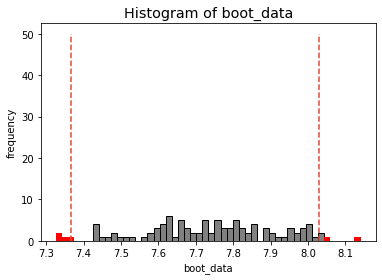

Отвергаем нулевую гипотезу


{'quants':         0
 0.03 7.37
 0.97 8.03,
 'p_value': 0.0}

In [113]:
get_bootstrap(df_ml_churn.age, df_ml_not_churn.age, boot_it = 100, statistic = np.mean, bootstrap_conf_level = 0.95, alpha = 0.05)

In [130]:
df_ml_not_churn.age.mean()

36.26173004225039

In [128]:
df_ml_churn.age.mean()

44.02007168458781

Разница в возрасте между оставшимися и ушедшими клиентами статистически значима.
Можно сказать, что люди, которые уходят, более старшего возраста, чем те, которые остаются. 

$\blacktriangleright$ Проверка гипотезы признака `estimated_salary` на то, что люди с высокой зарплатой уходят чаще, чем люди с низкой.

  0%|          | 0/100 [00:01<?, ?it/s]

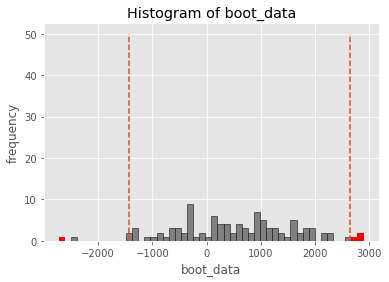

Не получилось отвергнуть нулевую гипотезу


{'quants':             0
 0.03 -1428.31
 0.97  2642.28,
 'p_value': 0.6379766643008893}

In [132]:
get_bootstrap(df_ml_churn.estimated_salary, df_ml_not_churn.estimated_salary, boot_it = 100, statistic = np.mean, bootstrap_conf_level = 0.95, alpha = 0.05)

Разница в размере заработной платы между оставшимися и ушедшими клиентами статистически незначима.
Зарплата не имеет значения на отток.

$\blacktriangleright$ Проверка гипотезы признака `balance` на то, что люди имеющим больший баланс на счете уходят чаще, чем люди с меньшим.

  0%|          | 0/100 [00:01<?, ?it/s]

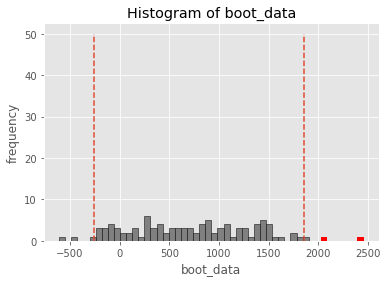

Не получилось отвергнуть нулевую гипотезу


{'quants':            0
 0.03 -261.90
 0.97 1856.24,
 'p_value': 0.2492712845470625}

In [133]:
get_bootstrap(df_ml_churn.balance, df_ml_not_churn.balance, boot_it = 100, statistic = np.mean, bootstrap_conf_level = 0.95, alpha = 0.05)

Размер баланса на счете клиента не влияет на отток.

$\blacktriangleright$ Проверка гипотезы признака `score	` на то, что те, кто уходит имеют более низкий кредитный рейтинг, чем те, кто остался с банком.

  0%|          | 0/100 [00:00<?, ?it/s]

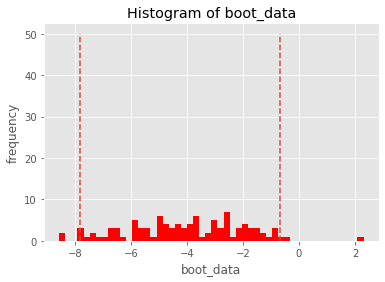

Не получилось отвергнуть нулевую гипотезу


{'quants':          0
 0.03 -7.83
 0.97 -0.69,
 'p_value': 0.05200576608817572}

In [134]:
get_bootstrap(df_ml_churn.score, df_ml_not_churn.score, boot_it = 100, statistic = np.mean, bootstrap_conf_level = 0.95, alpha = 0.05)

Гипотеза о том, что те кто уходит имеют более низкий кредитный рейтинг, чем те, кто остался с банком подтвердилась.

$\blacktriangleright$ Проверка гипотезы признака `gender` на то, как влияет гендерная принадлежность на отток.

In [171]:
from scipy.stats import ttest_ind

group1 = df_clean['gender'] == 'М'
group2 = df_clean['gender'] == 'Ж'
variable = df_clean['churn']

print((variable[group1].var(), variable[group2].var()))

(0.1560683893358876, 0.2057101604066581)


In [172]:
def check_ratio(What_check):
    a = df_clean.groupby([What_check, 'churn'])['user_id'].count().rename("ratio")
    b = a /  a.groupby(level=0).sum() 
    dfs = pd.DataFrame(data=b)
    return dfs.style.bar()

In [173]:
check_ratio('gender')

Статистика показывает, что гендерная принадлежность имеет значение на отток. Заметим, что больше покидают банк женщины.

$\blacktriangleright$ Проверка гипотезы признака `city` на то, в каком городе чаще происходит отток клиентов.

In [174]:
group_city_1 = df_clean['city'] == 'Ростов Великий'
group_city_2 = df_clean['city'] == 'Рыбинск'
group_city_3 = df_clean['city'] == 'Ярославль'
variable = df_clean['churn']

print((variable[group_city_1].var(), variable[group_city_2].var(), variable[group_city_3].var()))

(0.2199267744709244, 0.15007743020220243, 0.144928849090661)


In [175]:
check_ratio('city')

Здесь видно, что в банках г.Ростов Великий наибольший отток клиентов.

$\blacktriangleright$ Проверка гипотезы признака `objects` на то, в каком городе чаще происходит отток клиентов.

In [176]:
check_ratio('objects')

В случае с зависимостью количества объектов недвижимости и оттока не наблюдается.

$\blacktriangleright$ Проверка гипотезы признака `products` на то, что дежатели 4 банковских продуктов больше оттекают.

In [177]:
check_ratio('products')

Гипотезу о том, что держатели 4-х банковских продуктов больше оттекают, можем смело отвергнуть, т.к. соотношение с оставшимися клиентами с 4-мя продуктами нет. Также видим, что клиенты имеющие 2 банковских продукта - самые преданные.

$\blacktriangleright$ Проверка гипотезы признака `credit_card` на то, что владельцы кредитной карты более надежны.

In [179]:
check_ratio('credit_card')

Также видим, что наличие/отсутствие кредитной карты у клиента не влияет на отток.

$\blacktriangleright$ Проверка гипотезы признака `loyalty` на то, что лояльные клиенты чаще остаются с банком.

In [181]:
check_ratio('loyalty')

Гипотеза о том, что активные клиенты чаще остаются с банком подтвердилась.

### После проведенного исследовательского анализа построим примерный портрет клиента склонного к оттоку:
- клиент из города Ростов Великий
- не активный клиент
- является женщиной
- клиент с возрастом 44 года
- клиент, имеющий низкий кредитный рейтинг.

## Построение модели

In [253]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import itertools

#### Разделим данные на train/test
- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [254]:
X_train, X_test, y_train, y_test = train_test_split(df_clean.drop(['churn'], axis=1), df_clean['churn'], test_size=0.25, random_state=42, stratify=df_clean['churn'])

Соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля.

In [255]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [256]:
category_not_churn = ['city', 'gender', 'objects', 'products', 'credit_card', 'loyalty']

Посмотрим как это работает на примере отдельного категориального признака - gender

In [257]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='gender')),
                ('ohe', OHEEncoder(key='gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,gender_Ж,gender_М
4594,1,0
170,1,0
9146,0,1


Аналогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

In [258]:
numr = Pipeline([
                ('selector', NumberSelector(key='age')),            
            ])

numr.fit(X_train)
numr.transform(X_test).head(3)

,age
4594,31
170,29
9146,40


Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [259]:
final_transformers = list()

for cat_col in category_not_churn:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in interval_:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [260]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

In [261]:
models_results = {
    'approach': [],
    'F-Score': [],
    'Precision': [],
    'Recall': [],
}

### RandomForestClassifier

In [262]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42))
    ])

In [263]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('city',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='city')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='city'))])),
                                                ('gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='gender'))])),
                                                ('objects',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='objects')),
                                                                 ('ohe',...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='balance')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('estimated_salary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='estimated_salary')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [264]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.09, 0.21, 0.26, 0.13, 0.02, 0.1 , 0.14, 0.55, 0.45, 0.29])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [265]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.350000, F-Score=0.642, Precision=0.632, Recall=0.653


Отрисуем матрицу ошибок

In [266]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

C:\Users\User\AppData\Local\Temp\ipykernel_11148\856742999.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Confusion matrix, without normalization
[[999 125]
 [126 223]]


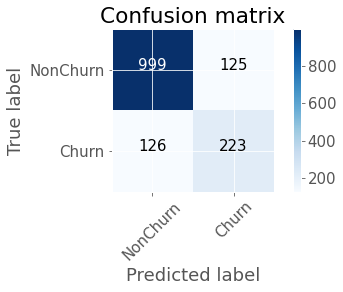

In [267]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

Видим, что модель предсказывала не случайно и чаще отвечала верно.

In [268]:
models_results['approach'].append('RandomForestClassifier')
models_results['F-Score'].append(0.642)
models_results['Precision'].append(0.632)
models_results['Recall'].append(0.653)

### LogisticRegression

для логистической регресси выполню масштабирование

In [269]:
scaler_std = StandardScaler()

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train_norm[interval_] = scaler_std.fit_transform(X_train_norm[interval_])
X_test_norm[interval_] = scaler_std.transform(X_test_norm[interval_])

In [270]:
pipeline.fit(X_train_norm, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('city',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='city')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='city'))])),
                                                ('gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='gender'))])),
                                                ('objects',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='objects')),
                                                                 ('ohe',...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='balance')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('estimated_salary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='estimated_salary')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [271]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test_norm)[:, 1]
preds[:10]

array([0.09, 0.21, 0.26, 0.13, 0.02, 0.1 , 0.14, 0.55, 0.45, 0.29])

In [272]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.350000, F-Score=0.642, Precision=0.632, Recall=0.653


C:\Users\User\AppData\Local\Temp\ipykernel_11148\856742999.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Confusion matrix, without normalization
[[999 125]
 [126 223]]


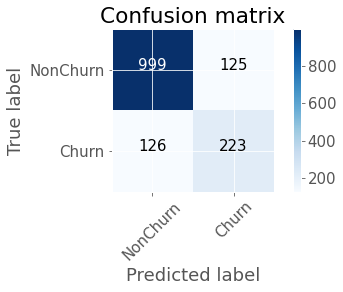

In [273]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

Видим, что модель предсказывала не случайно и чаще отвечала верно.

In [274]:
models_results['approach'].append('LogisticRegression')
models_results['F-Score'].append(0.642)
models_results['Precision'].append(0.632)
models_results['Recall'].append(0.653)

### XGBClassifier

In [306]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state = 0))
])

In [307]:
pipeline.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:11:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('city',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='city')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='city'))])),
                                                ('gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='gender'))])),
                                                ('objects',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='objects')),
                                                                 ('ohe',...
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [308]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.02943162, 0.03551967, 0.05630827, 0.06194966, 0.01010843,
       0.00611489, 0.22994694, 0.2927835 , 0.5165954 , 0.29034674],
      dtype=float32)

In [309]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.268643, F-Score=0.622, Precision=0.576, Recall=0.676


C:\Users\User\AppData\Local\Temp\ipykernel_11148\856742999.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Confusion matrix, without normalization
[[950 174]
 [114 235]]


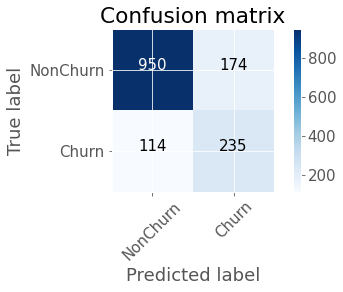

In [310]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

Видим, что модель предсказывала не случайно и чаще отвечала верно.

In [311]:
models_results['approach'].append('XGBClassifier')
models_results['F-Score'].append(0.622)
models_results['Precision'].append(0.576)
models_results['Recall'].append(0.676) 

In [312]:
pd.DataFrame( models_results)

,approach,F-Score,Precision,Recall
0,RandomForestClassifier,0.64,0.63,0.65
1,LogisticRegression,0.64,0.63,0.65
2,XGBClassifier,0.62,0.58,0.68
3,XGBClassifier,0.63,0.64,0.61
4,XGBClassifier,0.63,0.64,0.61
5,XGBClassifier,0.62,0.58,0.68


Очевидно, что мы не можем находить всех уходящих в отток клиентов и только их. Но, определив стратегию для удержания клиентов, мы можем подобрать нужные пороги по precision и recall. Например, можно сосредоточиться на удержании только высокодоходных клиентов или тех, кто уйдет с большей вероятностью. F-Score — среднее гармоническое precision и recall. F-Score достигает максимума при полноте и точности, равными единице, и близка к нулю, если один из аргументов близок к нулю.

Для задачи оттока, думаю, F-Score самая подходящая метрика, т.к. она держит баланс между метриками, но лучше смотреть на нее с большим уклоном на precision (precision обеспечивает максимальное содержание TP в предсказаниях модели, а значит мы не будем тратить неэффективно бюджет на FP)(в этом случае пользуемся моделью RandomForestClassifier или LogisticRegression). Хотя, если мы хотим охватить больше клиентов, то ориентируемся по recall и будет лучше использовать модель XGBClassifier.

### Оценка экономической эффективности

In [313]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

TN, FP, FN, TP

(950, 174, 114, 235)

In [314]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.673352435530086, 0.15480427046263345, 0.8451957295373665)

FPR (False Positive Rate) 0.15. Это значит, что 15 % клиентов определяются как "готовые к оттоку" некоректно. Для уменьшения FPR можем "лучше обучить модель" ("подкрутить" параметры).